# Custom block

Here is a more detailed example on how to create a custom block by subclassing the [Block](prose.Block) class (and make it user and community-friendly). The purpose of the [Block](prose.Block) we will create is to correct for [image vignetting](https://en.wikipedia.org/wiki/Vignetting)

## Dataset

We first consider an example image

In [1]:
from prose import example_image

image = example_image(seed=4)

in which we include some vignetting

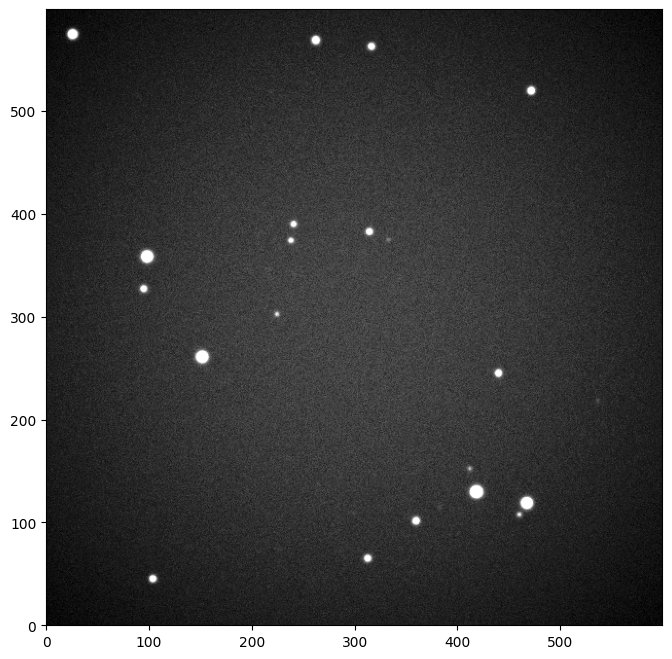

In [2]:
import numpy as np

# vignette function
def gaussian2D(XY, xy, sigma, amplitude=1):
    X, Y = XY
    x, y = xy
    return amplitude*np.exp(-((X-x)**2/sigma**2) -((Y-y)**2/sigma**2))**3

# vignetting the image data
XY = np.indices(image.shape)
vignette = gaussian2D(XY, (np.array(image.shape)/2), 1000)
image.data *= vignette
image.show()

## Method

The method to correct for the vignetting is simple:

1. We build a sigma-clipped version of the image to exclude bright (stars) pixels (iteratively)
2. We fit the vignette model to the sigma clipped data
3. We correct the image from the fitted vignette

### 1. Sigma clipping

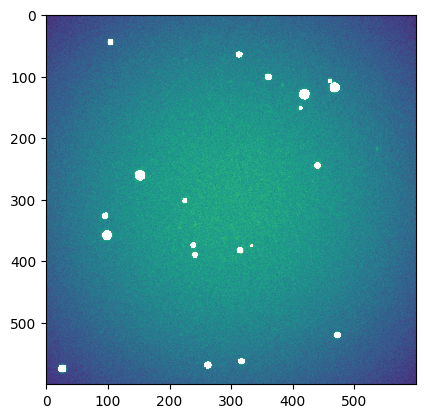

In [3]:
import matplotlib.pyplot as plt

sg_image = image.data.copy()

sg_image = image.data.copy()
mask = np.ones_like(sg_image).astype(bool)
for _ in range(5):
    mask = np.abs((sg_image - np.median(sg_image[mask]))) < 5*np.std(sg_image[mask])
sg_image[~mask] = np.nan

plt.imshow(sg_image)

### 2. Fitting the model

In [4]:
from scipy.optimize import minimize

center = np.array(image.shape)/2

def model(p):
    a, s = p
    return a*gaussian2D(XY, center, s)

def nll(p, sg_image):
    _model = model(p)
    return np.log(np.nansum((_model - sg_image)**2))

x0 = [5000, image.shape[0]]
sol = minimize(nll, x0, bounds=((0, np.nanmax(sg_image)), (0, 2000)), args=(sg_image,))

### 3. Correction

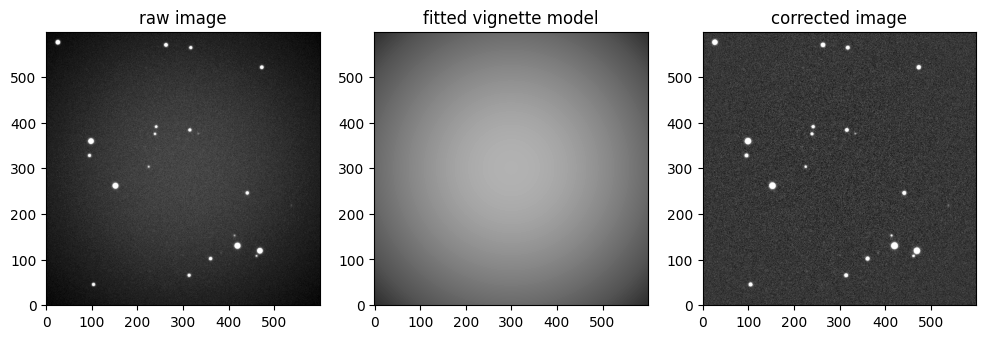

In [5]:
corrected_image = image.copy()
corrected_image.data -= model(sol.x)

# plotting
# --------
plt.figure(None, (12, 6))

ax1 = plt.subplot(131, title="raw image")
image.show(ax=ax1)

ax2 = plt.subplot(132, title="fitted vignette model")
plt.imshow(model(sol.x), origin="lower", cmap="Greys_r", vmin=np.nanmin(sg_image), vmax=np.nanmax(sg_image))

ax3 = plt.subplot(133, title="corrected image")
_ = corrected_image.show(ax=ax3)

## Block creation

We will now create a block to be able to apply this correction in a `Sequence` ( and easily associate it to other processing blocks)

### The simple way

The simpliest way is to subclass the [Block](prose.Block) class, and copy-paste the code above into its `run(self, image)` method, which will be called on each [Image](prose.Image)

In [6]:
from prose import Block

class SimpleVignettingCorr(Block):
    
    def __init__(self, **kwargs):
        super().__init__(self, **kwargs)
        
    def run(self, image):
        
        # 1. Sigma clipping
        sg_image = image.data.copy()
        mask = np.ones_like(sg_image).astype(bool)
        for _ in range(5):
            mask = np.abs((sg_image - np.median(sg_image[mask]))) < 5*np.std(sg_image[mask])
        sg_image[~mask] = np.nan
        
        XY = np.indices(image.shape)
        center = np.array(image.shape)/2
        
        # 2. Fitting the model
        def model(p):
            a, s = p
            return a*gaussian2D(XY, center, s)

        def nll(p, sg_image):
            _model = model(p)
            return np.log(np.nansum((_model - sg_image)**2))

        x0 = [5000, image.shape[0]]
        sol = minimize(nll, x0, bounds=((0, np.nanmax(sg_image)), (0, 2000)), args=(sg_image,))        
        
        # correction
        image.data -= model(sol.x)

and applying it to data

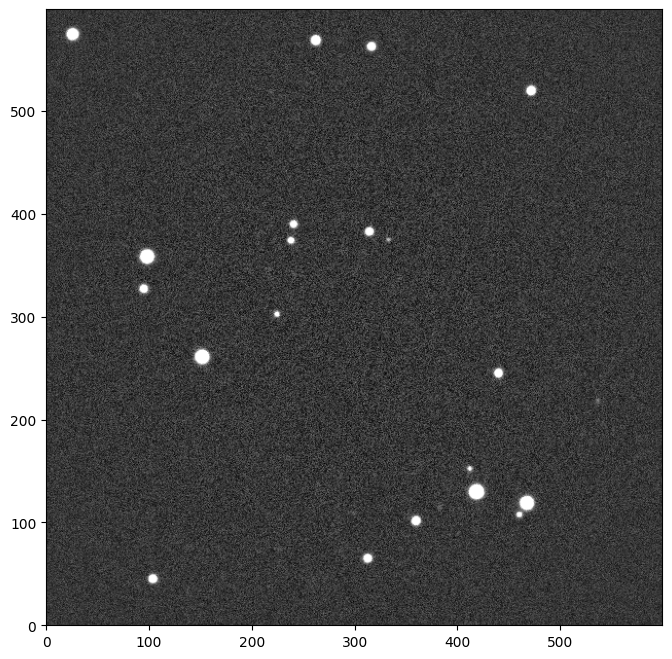

In [7]:
corrected_image = SimpleVignettingCorr()(image)
_ = corrected_image.show()

### User-friendly block

The block `SimpleVignettingCorr` does the work, but is not optimized. Indeed:
1. `XY` and `center` are computed for each image, whereas images with similar characteristics (like shape and center) are more likely to be fed into a sequence
2. The model parameters optimisation always start from an uninformed guess `x0`, whereas the solution from a previous image is likely to be a good guess
3. the code within `run` is lengthy and could be organized using class methods

A good way to solve 1. is to provide the block with a reference image, from which `XY` and `center` can be pre-computed. To solve 2., the last optmized parameters can be recorded and used as a first guess for the next optimization. Let's implement these two ideas in the block together with a bit of cleaning (solving 3.)

In [8]:
class BetterVignettingCorr(Block):
    
    # allowing for a reference image to be provided
    def __init__(self, reference=None, **kwargs):
        super().__init__(self, **kwargs)
        
        # to avoid re-computing it for every new image
        self.XY = None 
        self.center = None
        
        # to save last optimized parameters
        self.x0 = None
        
        # pre-computing parameters if reference provided
        if reference is not None:
            self.XY = np.indices(reference.shape)
            self.center = np.array(reference.shape)/2
            self.x0 = [5000, reference.shape[0]]
    
    @staticmethod
    def sigma_clip(data, n=5, sigma=5):
        sg_image = data.copy()
        mask = np.ones_like(sg_image).astype(bool)
        for _ in range(5):
            mask = np.abs((sg_image - np.median(sg_image[mask]))) < 5*np.std(sg_image[mask])
        sg_image[~mask] = np.nan
        return sg_image
    
    def model(self, p):
        a, s = p
        return a*gaussian2D(self.XY, self.center, s)

    def chi(self, p, sg_image):
        model = self.model(p)
        return np.nansum((model - sg_image)**2)
    
    def run(self, image):
        # sigma clipping
        sg_image = self.sigma_clip(image.data)
        
        # if no reference, using first image to initialize parameters
        if self.x0 is None:
            self.x0 = [5000, image.shape[0]]
        if self.XY is None:
            self.XY = np.indices(image.shape)
            self.center = np.array(image.shape)/2
            
        sol = minimize(self.chi, self.x0, bounds=((0, np.nanmax(sg_image)), (0, 2000)), args=(sg_image,))     
        self.x0 = sol.x # keeping optimized parameters as first guess for next image
        
        # correction
        image.data -= model(sol.x)

and applying it to data

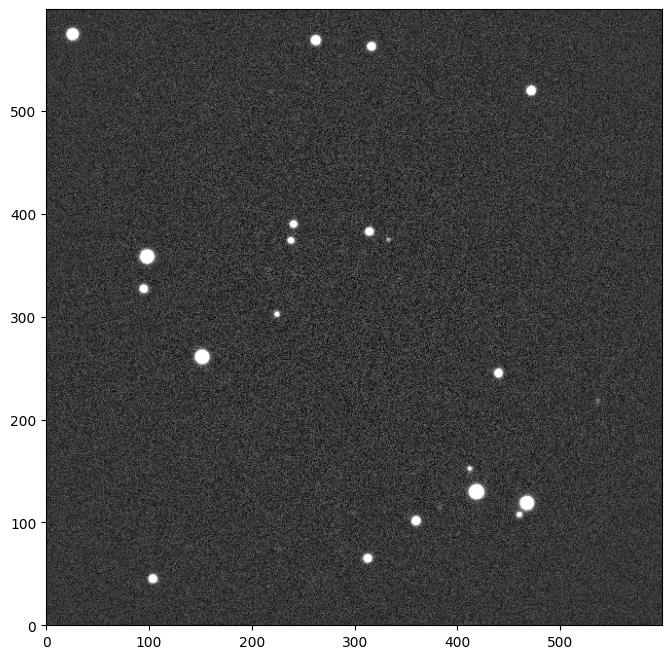

In [9]:
corrected_image = BetterVignettingCorr()(image)
_ = corrected_image.show()

```{note}
Here, the performance of ``BetterVignettingCorr`` against ``SimpleVignettingCorr`` would be very similar, but providing a reference mechanism to a block (so it can precompute some redundant parameters) often greatly improves its performances.
```

## Documentation

Once created, a Block needs to be properly documented in order to be shared and properly maintained.

### Acknowledgment

Using your `Block` in a `Sequence` might lead to published results. In this context, one would need to properly aknowledge the packages and methods used by your `Block`, including your own work. To do that, the `Block` class provide the `citations` method, that can be overwritten in the following way:

In [10]:
class CitableVignettingCorr(Block):
    
    def __init__(self, **kwargs):
        super().__init__(self, **kwargs)
        
    @property
    def citations(self):
        return (
            # we used scipy (known to prose)
            "scipy", 
            # your custom reference
            """@misc{my-work, author = "me", title = "My work", year = "2022"}""")

To use it, let's define a sequence with your block in it

In [11]:
from prose import Sequence, blocks

sequence = Sequence([
    CitableVignettingCorr(),
])

and extract the aknowledgment for it (TODO)

<div class="alert alert-info">

Note

For more details, see the [aknowledgment reference](./acknowledgement.ipynb)

</div>

TODO !

### Doctring

TODO